In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import math

In [3]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [4]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [5]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [6]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [7]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [8]:
#get starting points 
startingPoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        timePoint = row['Timestep'] + 1
        startingPoints.append(timePoint)

In [9]:
def getTimeFromStart(current, startList):
    currentEpisodeStartIndex = -1 #initialise negative value first
    for s in range(len(startList)):
        start = startList[s]
        if start - current > 0: 
            break 
        currentEpisodeStartIndex = s
    if currentEpisodeStartIndex >= 0:
        startPointTime = startList[currentEpisodeStartIndex]
        diff = current - startPointTime
        return int(diff)
    else: 
        return current

In [10]:
#get data on time elapsed from start of episode 
total_time_from_start = []
for timePoint in timeX:
    current_time_from_start = getTimeFromStart(timePoint, startingPoints)
    total_time_from_start.append(current_time_from_start)

In [11]:
all_df['Time_elapsed'] = total_time_from_start
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL,Time_elapsed
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0,0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0,1
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0,2
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0,3
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0,4
...,...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN,3
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN,4
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN,5
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN,6


In [12]:
#add anomaly data

#load anomaly detection model
anomalyDetector = tf.keras.models.load_model('AE_tuneActivation_code_relu.h5')

anomalyData = []

for index, row in all_df.iterrows():
    sensorReadings = np.array([row['Volt'], row['Rotate'], row['Pressure'], row['Vibration']])
    sensorReadings = np.reshape(sensorReadings, (1,4))
    predictions = anomalyDetector.predict(sensorReadings)
    anomalyScore = (np.mean(np.power(sensorReadings - predictions, 2), axis=1))**0.5
    
    if anomalyScore < 0.0838:
        isAnomaly = 0
    else:
        isAnomaly = 1
        
    anomalyData.append(isAnomaly)
    
all_df['Anomalous'] = anomalyData

In [13]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL,Time_elapsed,Anomalous
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0,0,0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0,1,0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0,2,0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0,3,0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0,4,0
...,...,...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0,7,0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0,8,0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0,9,0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0,10,1


In [14]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['Time_elapsed'], row['Anomalous'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [15]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [16]:
def splitDataIntoChunks3DWithAnomalyTimeInfo(data, chunk_size):
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    episode_chunk.append(reading[1:7])
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][7])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [17]:
#set random seed 
tf.random.set_seed(42)

In [18]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

In [19]:
(trainX_4step_TAD, trainY_4step_TAD, trainTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(train_data, 4)
(valX_4step_TAD, valY_4step_TAD, valTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(val_data, 4)
(testX_4step_TAD, testY_4step_TAD, testTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(test_data, 4)

In [20]:
#check shape of X (training)
trainX_4step_TAD_arr = np.array(trainX_4step_TAD)
trainX_4step_TAD_arr.shape

(4022, 4, 6)

In [21]:
#check shape of y (training)
trainY_4step_TAD_arr = np.array(trainY_4step_TAD)
trainY_4step_TAD_arr = trainY_4step_TAD_arr.reshape(-1, 1)
trainY_4step_TAD_arr.shape

(4022, 1)

In [22]:
#check shape of X (validation)
valX_4step_TAD_arr = np.array(valX_4step_TAD)
valX_4step_TAD_arr.shape

(635, 4, 6)

In [23]:
#check shape of y (validation)
valY_4step_TAD_arr = np.array(valY_4step_TAD)
valY_4step_TAD_arr = valY_4step_TAD_arr.reshape(-1, 1)
valY_4step_TAD_arr.shape

(635, 1)

In [24]:
model2 = tf.keras.models.load_model("CNN_tuned_withTime2.h5")

In [25]:
#performance on training set
trainPredict2 = model2.predict(trainX_4step_TAD_arr)
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY_4step_TAD_arr, trainPredict2))
trainR2Score2 = r2_score(trainY_4step_TAD_arr, trainPredict2)
trainSscore2 = findSscore(trainY_4step_TAD_arr, trainPredict2)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore2, trainR2Score2, trainSscore2))

Train Score: 4.0311 RMSE 0.1296 R2 Score 5325.8737 S score


In [26]:
#performance on validation set
valPredict2 = model2.predict(valX_4step_TAD_arr)
# calculate root mean squared error
valScore2 = math.sqrt(mean_squared_error(valY_4step_TAD_arr, valPredict2))
valR2Score2 = r2_score(valY_4step_TAD_arr, valPredict2)
valSscore2 = findSscore(valY_4step_TAD_arr, valPredict2)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore2, valR2Score2, valSscore2))

Validation Score: 2.8366 RMSE 0.2976 R2 Score 785.6241 S score


In [27]:
allRUL = all_df['RUL']

In [28]:
def getRULValues(predictions, actual, timeList, startIndex, endIndex):
    actualValues = []
    predictedValues = []
    for timestep in range(startIndex, endIndex+1):
        actualValues.append(actual[timestep])
        if timestep in timeList:
            requiredIndex = timeList.index(timestep)
            predictedValues.append(predictions[requiredIndex])
        else:
            predictedValues.append(0)
    return (actualValues, predictedValues)

In [29]:
(actualTrain2, predictedTrain2) = getRULValues(trainPredict2, allRUL, trainTime_4step_TAD, 0, 6009)
(actualVal2, predictedVal2) = getRULValues(valPredict2, allRUL, valTime_4step_TAD, 6010, 6976)

In [30]:
#find timesteps for each episode
def findTimestepsPerEpisode(data):
    output = []
    for episode in data:
        episode_time = []
        for instance in episode:
            timestep = int(instance[0])
            episode_time.append(timestep)
        output.append(episode_time)
    return output

In [31]:
valEpisode_Time = findTimestepsPerEpisode(val_data)

In [32]:
def findRULPredictedEachEpisode(predictions, timeList, episodeTimeList):
    predictedValuesAllEpisodes = []
    for episode in episodeTimeList:
        predictRULEpisode = []
        for timestep in episode[:-1]: 
            #exclude last timestep since failure
            if timestep in timeList:
                index = timeList.index(timestep)
                predictedValue = predictions[index][0]
                predictRULEpisode.append(predictedValue)
        predictedValuesAllEpisodes.append(predictRULEpisode)
    return predictedValuesAllEpisodes

In [33]:
valPredict_Episodes = findRULPredictedEachEpisode(valPredict2, valTime_4step_TAD, valEpisode_Time)

In [34]:
valPredict_Episodes

[[6.4174175,
  5.69571,
  5.2754154,
  4.827429,
  4.3029776,
  3.9096746,
  3.929145,
  3.5537248,
  3.5062726],
 [],
 [6.1096907,
  5.1416764,
  4.662638,
  4.590067,
  4.305699,
  4.1230803,
  3.5057843,
  2.9689872],
 [7.230675, 6.3991013, 5.326668, 2.6566844, 2.177749],
 [6.728034,
  6.007189,
  5.1691694,
  4.5330076,
  4.144803,
  4.078834,
  3.8332908,
  3.777937,
  3.391351,
  2.705617,
  2.3658154],
 [6.3384957, 6.1960135, 5.015624],
 [6.94369,
  6.1428604,
  5.460983,
  4.503948,
  4.051606,
  4.1038694,
  3.840103,
  3.372923,
  2.8082135],
 [6.4450645,
  4.6037188,
  4.9173183,
  5.243086,
  5.1411924,
  4.5895424,
  4.4208164,
  3.985574,
  2.3058996],
 [6.9847794,
  6.0138555,
  5.324556,
  4.8044376,
  4.7170877,
  4.352425,
  2.380914,
  1.783114,
  1.7551137],
 [],
 [6.359241],
 [6.1558094, 5.3864355, 4.7909527],
 [6.875349, 5.7370033, 4.1299973],
 [6.436821, 5.268514, 4.75133, 4.533641, 4.272429, 3.9424095],
 [8.586287, 5.7465353, 5.522024, 4.8516626, 4.4990015],
 [6

In [35]:
def findMinPredictionsAllEpisode(predictedValuesEpisode):
    minValues = []
    for episode in predictedValuesEpisode:
        if len(episode):
            minPrediction = min(episode)
            minValues.append(minPrediction)
    return minValues

In [36]:
valPredict_min = findMinPredictionsAllEpisode(valPredict_Episodes)

In [37]:
valPredict_min

[3.5062726,
 2.9689872,
 2.177749,
 2.3658154,
 5.015624,
 2.8082135,
 2.3058996,
 1.7551137,
 6.359241,
 4.7909527,
 4.1299973,
 3.9424095,
 4.4990015,
 4.211961,
 3.3743522,
 3.2100174,
 5.817223,
 3.7751157,
 2.3192937,
 1.9346453,
 3.1353352,
 6.0041656,
 5.0315495,
 4.82345,
 3.810684,
 1.7498935,
 2.9798434,
 6.723418,
 4.6752977,
 5.6246967,
 1.7499272,
 1.7507669,
 1.7500732,
 1.7559928,
 1.7498935,
 2.1455824,
 1.7612008,
 1.8717324,
 3.7161214,
 3.531262,
 5.737688,
 1.7499722,
 3.173648,
 2.9902263,
 1.7571455,
 1.7929641,
 1.7509907,
 3.8161461,
 6.6363664,
 2.7385035,
 4.63304,
 2.8788679,
 2.0346143,
 2.0873175,
 2.5749876,
 2.839545,
 2.3489888,
 4.580985,
 1.7506205,
 1.9726955,
 5.5254908,
 1.7501408,
 2.7815447,
 2.9086945,
 3.1888566,
 4.4120483,
 2.7063313,
 2.2873695,
 2.189113,
 4.130186,
 4.5208783,
 2.5999918,
 4.045227,
 2.6424892,
 2.7172382,
 5.242237,
 4.1613836,
 1.7572039,
 5.191607,
 1.7539389]

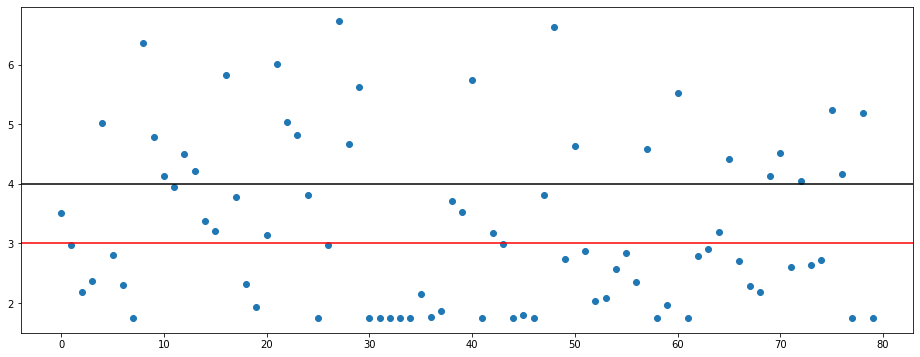

In [38]:
#plot scatter plot
indexes = [i for i in range(len(valPredict_min))]
plt.figure(figsize=(16, 6))
plt.scatter(indexes, valPredict_min)
plt.axhline(y=4, color='k', linestyle='-')
plt.axhline(y=3, color='red', linestyle='-')
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x22601d1d1f0>,
 'caps': [<matplotlib.lines.Line2D at 0x22601d1d8b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x22601d01e50>],
 'medians': [<matplotlib.lines.Line2D at 0x22601d1df70>],
 'fliers': [<matplotlib.lines.Line2D at 0x22601d27310>],
 'means': []}

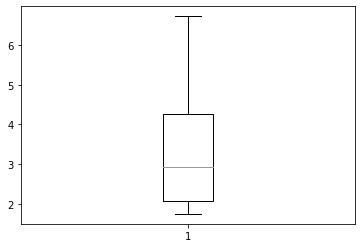

In [39]:
#plot boxplot
plt.boxplot(valPredict_min)

In [40]:
max(valPredict_min)

6.723418

In [41]:
#find percentage of degradation failure episodes
def findDegradationEpisodesPercentage(data):
    episodeCount = 0
    degradationEpisodeCount = 0
    for episode in data:
        episodeCount += 1
        lastInstance = episode[-1]
        lastState = lastInstance[-1]
        if lastState == 4:
            degradationEpisodeCount += 1
    return degradationEpisodeCount/episodeCount

In [42]:
#arrange values from small to large
valPredict_min_sorted = sorted(valPredict_min)
valPredict_min_sorted

[1.7498935,
 1.7498935,
 1.7499272,
 1.7499722,
 1.7500732,
 1.7501408,
 1.7506205,
 1.7507669,
 1.7509907,
 1.7539389,
 1.7551137,
 1.7559928,
 1.7571455,
 1.7572039,
 1.7612008,
 1.7929641,
 1.8717324,
 1.9346453,
 1.9726955,
 2.0346143,
 2.0873175,
 2.1455824,
 2.177749,
 2.189113,
 2.2873695,
 2.3058996,
 2.3192937,
 2.3489888,
 2.3658154,
 2.5749876,
 2.5999918,
 2.6424892,
 2.7063313,
 2.7172382,
 2.7385035,
 2.7815447,
 2.8082135,
 2.839545,
 2.8788679,
 2.9086945,
 2.9689872,
 2.9798434,
 2.9902263,
 3.1353352,
 3.173648,
 3.1888566,
 3.2100174,
 3.3743522,
 3.5062726,
 3.531262,
 3.7161214,
 3.7751157,
 3.810684,
 3.8161461,
 3.9424095,
 4.045227,
 4.1299973,
 4.130186,
 4.1613836,
 4.211961,
 4.4120483,
 4.4990015,
 4.5208783,
 4.580985,
 4.63304,
 4.6752977,
 4.7909527,
 4.82345,
 5.015624,
 5.0315495,
 5.191607,
 5.242237,
 5.5254908,
 5.6246967,
 5.737688,
 5.817223,
 6.0041656,
 6.359241,
 6.6363664,
 6.723418]

In [43]:
#find index cutoff
degradationPercentage = findDegradationEpisodesPercentage(val_data)
cutoff_Index = int(degradationPercentage*len(valPredict_min_sorted))
cutoffValue = valPredict_min_sorted[cutoff_Index]
cutoffValue

5.737688

Find RUL predictions by state

In [44]:
def getStateValuesByChunk(data, state, chunk_size):
    stateValues = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                currentState = int(episode[order+chunk_size][8])
                if currentState == state:
                    stateValues.append(int(episode[order+chunk_size][0]))
    return stateValues

In [45]:
def findRULValuesByState(RULlist, timeList, data, state, chunk_size):
    stateRulValues = []
    stateTimeList = getStateValuesByChunk(data, state, chunk_size)
    for s in stateTimeList:
        specificIndex = timeList.index(s)
        specificRUL = RULlist[specificIndex][0]
        stateRulValues.append(specificRUL)
    return stateRulValues

In [46]:
from statistics import mean
def findMinMaxMean(values):
    minValue = min(values)
    maxValue = max(values)
    meanValue = mean(values)
    print("Min value is %f. Mean value is %f. Max Value is %f" % (minValue, meanValue, maxValue))

State 0

In [47]:
#state 0 
state0RUL = findRULValuesByState(valPredict2, valTime_4step_TAD, val_data, 0, 4)
state0RUL

[6.4174175,
 6.4564896,
 6.9915137,
 6.979486,
 5.7449636,
 4.385878,
 4.2836,
 4.010434,
 6.4020596,
 5.81798,
 5.485298,
 4.8571243,
 6.3353477,
 6.2386365,
 5.8693457,
 5.5168467,
 5.159768,
 4.6896753,
 3.729563,
 8.963265,
 8.495266,
 6.999954,
 6.987333,
 6.0357203,
 5.2549562,
 6.094569]

In [48]:
#state 0
findMinMaxMean(state0RUL)

Min value is 3.729563. Mean value is 5.930865. Max Value is 8.963265


{'whiskers': [<matplotlib.lines.Line2D at 0x22601612c10>,
 'caps': [<matplotlib.lines.Line2D at 0x22601b5b820>,
 'boxes': [<matplotlib.lines.Line2D at 0x22601612d60>],
 'medians': [<matplotlib.lines.Line2D at 0x22601b5bfa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22601b5b190>],
 'means': []}

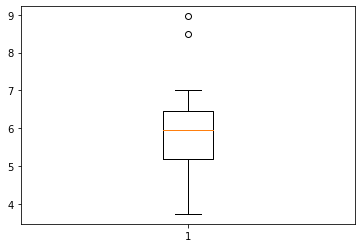

In [49]:
#plot boxplot
plt.boxplot(state0RUL)

State 1

In [50]:
#state 1 
state1RUL = findRULValuesByState(valPredict2, valTime_4step_TAD, val_data, 1, 4)
state1RUL

[5.69571,
 5.2754154,
 4.827429,
 4.3029776,
 3.9096746,
 3.929145,
 6.728034,
 6.007189,
 5.1691694,
 4.5330076,
 6.94369,
 6.1428604,
 5.460983,
 6.4450645,
 4.6037188,
 4.9173183,
 5.243086,
 5.1411924,
 4.5895424,
 4.4208164,
 6.9847794,
 6.0138555,
 5.324556,
 4.8044376,
 6.436821,
 5.268514,
 4.75133,
 4.533641,
 8.586287,
 6.401209,
 4.736498,
 7.347124,
 6.2185297,
 5.008321,
 6.693556,
 6.133028,
 5.374279,
 4.6284094,
 3.6348026,
 3.293599,
 3.1074278,
 3.1259067,
 7.0924854,
 4.278036,
 3.9731004,
 6.5024824,
 5.533061,
 7.0322533,
 5.4178233,
 7.0016723,
 5.8608465,
 6.526889,
 7.670491,
 2.2980616,
 1.9010676,
 6.1328764,
 7.635066,
 5.391991,
 6.304311,
 5.3192687,
 6.7212253,
 6.133817,
 5.1834264,
 5.1528883,
 5.2697525,
 4.9599495,
 4.1924453,
 3.7161214,
 6.324836,
 6.3106523,
 7.024638,
 6.4093513,
 10.005701,
 7.1288724,
 5.9438143,
 5.558333,
 5.0336394,
 5.203369,
 4.888263,
 6.7094603,
 5.5696297,
 8.47447,
 6.7486486,
 6.7517166,
 6.081473,
 5.445734,
 4.570476,

In [51]:
#state 1
findMinMaxMean(state1RUL)

Min value is 1.901068. Mean value is 5.645136. Max Value is 11.219241


{'whiskers': [<matplotlib.lines.Line2D at 0x2260133a640>,
 'caps': [<matplotlib.lines.Line2D at 0x2267ffb29d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2260133a340>],
 'medians': [<matplotlib.lines.Line2D at 0x2267ffb24c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2267ffb2d00>],
 'means': []}

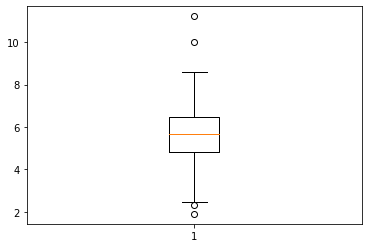

In [52]:
#plot boxplot
plt.boxplot(state1RUL)

State 2

In [53]:
#state 2 
state2RUL = findRULValuesByState(valPredict2, valTime_4step_TAD, val_data, 2, 4)
state2RUL

[3.5537248,
 6.1096907,
 5.1416764,
 4.662638,
 4.590067,
 7.230675,
 6.3991013,
 4.144803,
 4.078834,
 3.8332908,
 3.777937,
 3.391351,
 6.3384957,
 4.503948,
 4.051606,
 4.1038694,
 3.985574,
 4.7170877,
 6.875349,
 4.272429,
 5.7465353,
 5.522024,
 6.0472784,
 5.689218,
 5.534089,
 5.122216,
 4.709174,
 4.855937,
 4.6859164,
 4.6852508,
 4.3269434,
 3.8260353,
 3.4468377,
 3.275116,
 6.651045,
 4.3544226,
 2.5336509,
 2.1394427,
 6.3687825,
 5.1409793,
 4.329156,
 4.0087347,
 3.7182393,
 6.6758814,
 6.6920757,
 5.724122,
 7.5463905,
 3.973138,
 3.0033429,
 4.778057,
 4.896829,
 4.41736,
 3.7520082,
 3.8117816,
 3.3265994,
 3.0680678,
 7.061737,
 5.0798855,
 5.4826946,
 4.6234293,
 4.2207346,
 6.5256414,
 5.9537516,
 5.4705095,
 5.2222395,
 7.3378124,
 6.1642284,
 2.9415934,
 2.0377038,
 1.7500732,
 2.2512498,
 2.3896148,
 1.9685494,
 1.7559928,
 1.7653964,
 5.4981112,
 4.7798862,
 4.5770183,
 6.810157,
 6.2766685,
 3.248629,
 3.143268,
 3.742309,
 2.1888874,
 2.1455824,
 2.8524554,


In [54]:
#state 2
findMinMaxMean(state2RUL)

Min value is 1.750073. Mean value is 4.529821. Max Value is 7.703734


{'whiskers': [<matplotlib.lines.Line2D at 0x226011e5460>,
 'caps': [<matplotlib.lines.Line2D at 0x2267ebe02b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x226011e57c0>],
 'medians': [<matplotlib.lines.Line2D at 0x2267ebe0d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x2267ebe0040>],
 'means': []}

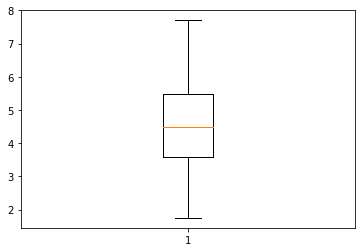

In [55]:
#plot boxplot
plt.boxplot(state2RUL)

State 3

In [56]:
#state 3 
state3RUL = findRULValuesByState(valPredict2, valTime_4step_TAD, val_data, 3, 4)
state3RUL

[3.5062726,
 4.305699,
 4.1230803,
 3.5057843,
 2.9689872,
 5.326668,
 2.6566844,
 2.177749,
 2.705617,
 2.3658154,
 6.1960135,
 5.015624,
 3.840103,
 3.372923,
 2.8082135,
 2.3058996,
 4.352425,
 2.380914,
 1.783114,
 1.7551137,
 6.359241,
 6.1558094,
 5.3864355,
 4.7909527,
 5.7370033,
 4.1299973,
 3.9424095,
 4.8516626,
 4.4990015,
 4.211961,
 4.0195594,
 3.7620828,
 3.3743522,
 3.2100174,
 5.817223,
 3.7751157,
 4.0665216,
 2.3192937,
 1.9346453,
 3.4536648,
 3.288521,
 3.1353352,
 6.0041656,
 5.0315495,
 5.9516816,
 4.82345,
 3.810684,
 3.1014621,
 1.8657496,
 1.7498935,
 1.7545708,
 2.471738,
 2.5086691,
 2.7318578,
 3.1037323,
 2.9798434,
 6.723418,
 4.6752977,
 6.3638353,
 5.6246967,
 3.973014,
 2.2758324,
 1.8983222,
 1.7499272,
 3.5751393,
 2.2615976,
 1.7507669,
 1.7596952,
 2.2379308,
 2.472893,
 2.7339375,
 3.1665905,
 2.2057197,
 1.7779969,
 1.7671756,
 1.7653838,
 1.7619532,
 4.429727,
 3.7159808,
 3.2130034,
 2.12612,
 1.7498935,
 2.7501438,
 2.6740105,
 3.2012386,
 2.1

In [57]:
#state 3
findMinMaxMean(state3RUL)

Min value is 1.749894. Mean value is 3.488425. Max Value is 7.377325


{'whiskers': [<matplotlib.lines.Line2D at 0x2267fe36490>,
 'caps': [<matplotlib.lines.Line2D at 0x2267d71f970>,
 'boxes': [<matplotlib.lines.Line2D at 0x2267fe36880>],
 'medians': [<matplotlib.lines.Line2D at 0x2267d71f250>],
 'fliers': [<matplotlib.lines.Line2D at 0x2267d71f5b0>],
 'means': []}

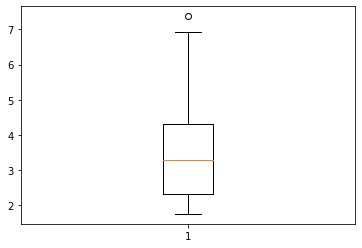

In [58]:
#plot boxplot
plt.boxplot(state3RUL)

State 4

In [59]:
#state 4 
state4RUL = findRULValuesByState(valPredict2, valTime_4step_TAD, val_data, 4, 4)
state4RUL

[3.2059643,
 2.770444,
 2.8721416,
 2.1667871,
 4.263155,
 2.447316,
 1.7632297,
 2.109566,
 4.6760283,
 5.2941065,
 4.432777,
 3.32038,
 2.2920945,
 2.3994565,
 3.5246499,
 2.1509244,
 2.1215937,
 2.481181,
 1.7577757,
 1.784088,
 2.7519777,
 5.1147766,
 2.524427,
 2.431318,
 2.2704284,
 2.4594285,
 2.3428671,
 4.1301875,
 5.1138353,
 1.7532057,
 1.8608092,
 1.7521452,
 1.7669266,
 1.8394748,
 2.44296,
 1.7559582,
 1.7567247,
 3.286557,
 6.289236,
 4.9117837,
 1.7498935,
 2.855538,
 3.0202787,
 1.7555718,
 1.7691231,
 1.7574469,
 3.5837297,
 5.186017,
 2.0576103,
 2.5024016,
 2.431103,
 2.1969242,
 2.3214366,
 3.2901213,
 2.0132976,
 2.9995873,
 2.6647747,
 1.7765268,
 2.829016,
 4.838604,
 1.809248,
 2.589729,
 2.0808408,
 3.8091812,
 3.977845,
 2.092372,
 1.7536902,
 3.8129046,
 2.2405956,
 4.7657733,
 1.9728752,
 2.299878,
 4.590916,
 3.5829628,
 1.7582185,
 4.5355525,
 1.7570059]

In [60]:
#state 4
findMinMaxMean(state4RUL)

Min value is 1.749894. Mean value is 2.849575. Max Value is 6.289236


{'whiskers': [<matplotlib.lines.Line2D at 0x2267d4109a0>,
 'caps': [<matplotlib.lines.Line2D at 0x2265b675520>,
 'boxes': [<matplotlib.lines.Line2D at 0x2267d410460>],
 'medians': [<matplotlib.lines.Line2D at 0x2267d63df70>],
 'fliers': [<matplotlib.lines.Line2D at 0x2267d63daf0>],
 'means': []}

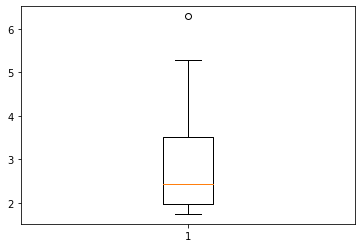

In [61]:
#plot boxplot
plt.boxplot(state4RUL)

State 5

In [62]:
#state 5 
state5RUL = findRULValuesByState(valPredict2, valTime_4step_TAD, val_data, 5, 4)
state5RUL

[2.7591908, 5.97952, 3.1755726, 3.5424733, 4.3624964]

In [63]:
#state 5
findMinMaxMean(state5RUL)

Min value is 2.759191. Mean value is 3.963850. Max Value is 5.979520


{'whiskers': [<matplotlib.lines.Line2D at 0x2267ff3d460>,
 'caps': [<matplotlib.lines.Line2D at 0x2267ff3d9a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2267ff3dd60>],
 'medians': [<matplotlib.lines.Line2D at 0x2267d638fa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2267feb4dc0>],
 'means': []}

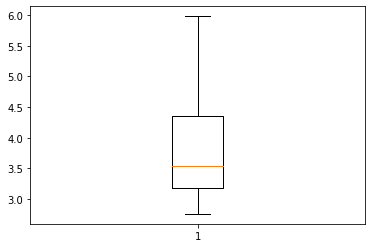

In [64]:
#plot boxplot
plt.boxplot(state5RUL)

Original RUL Threshold may be too high

In [65]:
def findPercentageBelowValue(values, threshold):
    totalCount = len(values)
    desiredCount = 0
    for x in values:
        if x <= threshold:
            desiredCount += 1
    return desiredCount/totalCount

Current RUL threshold is more than state 1

In [66]:
#state 1
findPercentageBelowValue(valPredict2, 5.645136)

0.7700787401574803

In [67]:
#state 2
findPercentageBelowValue(valPredict2, 4.529821)

0.5574803149606299

In [68]:
#state 3
findPercentageBelowValue(valPredict2, 3.488425)

0.32755905511811023

Set at state 1 threshold